# Tarefa Dataset Grupo

### Produção Energética e Sustentabilidade

https://www.kaggle.com/competitions/daasbstp2023

Imports Necessários

In [248]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import re
import seaborn as sns
import pylab as pl

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

#!conda install -c conda-forge lightgbm
#!pip install lightgbm
from lightgbm import LGBMClassifier




<h2>Ingestão de Dados

In [249]:
#Dados de Treino
df_energia_2021 = pd.read_csv('energia_202109-202112.csv',na_filter=False)
df_energia_2022 = pd.read_csv('energia_202201-202212.csv',na_filter=False)
df_meteo_2021 = pd.read_csv('meteo_202109-202112.csv',na_filter=False)
df_meteo_2022 = pd.read_csv('meteo_202201-202212.csv',na_filter=False)

#Verificação se os datasets foram carregados corretamente
print (df_energia_2021.shape)
print (df_energia_2022.shape)
print (df_meteo_2021.shape)
print (df_meteo_2022.shape)

#Dados de Teste

df_energia_2023 = pd.read_csv('energia_202301-202304.csv')
df_meteo_2023 = pd.read_csv('meteo_202301-202304.csv')

#Verificação se os datasets foram carregados corretamente

print (df_energia_2023.shape)
print (df_meteo_2023.shape)


(2256, 6)
(8760, 6)
(2928, 15)
(8760, 15)
(2256, 5)
(1752, 15)


<h3>Pré-Tratamento de Dados

In [250]:
#ver os cabeçalhos para fazer merge por data e hora (Verificar o tratamento que temos que fazer)

print(df_energia_2021.head())
print(df_meteo_2021.head())

#ver os tipos de dados que o campo Data e Hora utilizavam no dataset de energia(garantir as mesmas unidades)
print (df_energia_2021.dtypes)


lista=[df_meteo_2021,df_meteo_2022,df_meteo_2023] 

#epressão regular para retirar os campos data e Hora através de grupos de captura
form = re.compile(r'(\d{4}-\d{2}-\d{2})\s(\d{2}):\d{2}:\d{2}\s\+\d{4}\sUTC')

for elem in lista:
    data= elem['dt_iso'].str.extract(form)
    elem['Data']= data[0]
    elem['Hora']= pd.to_numeric(data[1])

#Verificar se as alterações ocorreram com sucesso
print(df_meteo_2021.head())



         Data  Hora  Normal (kWh)  Horario Economico (kWh)  Autoconsumo (kWh)  \
0  2021-09-29     0           0.0                      0.0                0.0   
1  2021-09-29     1           0.0                      0.0                0.0   
2  2021-09-29     2           0.0                      0.0                0.0   
3  2021-09-29     3           0.0                      0.0                0.0   
4  2021-09-29     4           0.0                      0.0                0.0   

  Injecao na rede (kWh)  
0                  None  
1                  None  
2                  None  
3                  None  
4                  None  
           dt                         dt_iso city_name   temp  feels_like  \
0  1630454400  2021-09-01 00:00:00 +0000 UTC     local  18.74       18.84   
1  1630458000  2021-09-01 01:00:00 +0000 UTC     local  18.73       18.83   
2  1630461600  2021-09-01 02:00:00 +0000 UTC     local  17.84       17.98   
3  1630465200  2021-09-01 03:00:00 +0000 UTC     

<h3>Merge dos Dados

In [251]:
#Dados de Treino
df_2021 = pd.merge(df_energia_2021,df_meteo_2021, how='inner', on=['Data','Hora']) 
df_2022 = pd.merge(df_energia_2022,df_meteo_2022, how='inner', on=['Data','Hora'])

#Construção do dataset de treino
df_train= pd.concat([df_2021, df_2022], ignore_index=True)

In [252]:
#Analise aos dados 

df_teste=pd.read_csv('teste_correspondencia.csv')
form = re.compile(r'(\d{4}-\d{2}-\d{2})T(\d{2}):\d{2}')

#desdobrar data para o dataset meteorológico de 2021
data= df_teste['time'].str.extract(form)
df_teste['Data']= data[0]
df_teste['Hora']= pd.to_numeric(data[1])
#df_meteo_2021['Data'], df_meteo_2021['Hora'] = zip(*df_meteo_2021['dt_iso'].str.extract(form).values)
df_teste.drop(['time'], axis='columns', inplace=True) 
df_teste = pd.merge(df_meteo_2023,df_teste, how='inner', on=['Data','Hora']) 

print("TESTEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")
print(df_teste)

contagem_por_grupo = df_teste.groupby(['weather_description', 'weather_code (wmo code)']).size().reset_index(name='contagem')
print(contagem_por_grupo)




#NOVOS DADOS 
df_meteo_2023_nd = pd.read_csv('meteorologia_2023.csv')
print(df_meteo_2023_nd.columns)


form = re.compile(r'(\d{4}-\d{2}-\d{2})T(\d{2}):\d{2}')

#desdobrar data para o dataset meteorológico de 2021
data= df_meteo_2023_nd['time'].str.extract(form)
df_meteo_2023_nd['Data']= data[0]
df_meteo_2023_nd['Hora']= pd.to_numeric(data[1])
#df_meteo_2021['Data'], df_meteo_2021['Hora'] = zip(*df_meteo_2021['dt_iso'].str.extract(form).values)
df_meteo_2023_nd.drop(['time'], axis='columns', inplace=True)
print(df_meteo_2023_nd.columns)

#tentar converter os valores
#df_meteo_2023_nd.drop(['weather_code (wmo code)'], axis='columns', inplace=True)

df_meteo_2023= pd.concat([df_meteo_2023, df_meteo_2023_nd], ignore_index=True)
df_meteo_2023.drop(['w'], axis='columns', inplace=True)



print("AQUIIIIIIIIIIIIIIIIIIIIIIIIIIII")
print(df_meteo_2023)




df_2023 = pd.merge(df_energia_2023,df_meteo_2023, how='left', on=['Data','Hora']) 

def extrair_mes_dia(row):
    # Use uma expressão regular para encontrar o mês e o dia na data
    padrao = r"\d{4}-(\d{2}-\d{2})"
    correspondencia = re.match(padrao, row['Data'])
    
    # Use os grupos capturados para obter o mês e o dia
    mes= correspondencia.group(1)
    return mes

def periodo_dia(row):
    if  row['Sunrise']<= row['Hora'] < 12:
    #if  8< row['Hora'] < 12:
        return 0
    elif 12 <= row['Hora'] < row['Sunset']:
    #elif 12 <= row['Hora'] < 8:
        return 1
    else:
        return 2

df_sunrise = pd.read_csv('data.csv')
for df in [df_train,df_2023]:
    df['Dia'] = df.apply(extrair_mes_dia, axis=1) 

df_train = pd.merge(df_train,df_sunrise, how='inner', on=['Dia'])
df_train['Periodo']= df_train.apply(periodo_dia, axis=1)
print(df_train.head())
df_train.drop('Dia',axis='columns', inplace=True)
df_train.drop('Sunset',axis='columns', inplace=True)
df_train.drop('Sunrise',axis='columns', inplace=True)

df_2023 = pd.merge(df_2023,df_sunrise, how='inner', on=['Dia'])
df_2023['Periodo']= df_2023.apply(periodo_dia, axis=1)
print(df_2023.head())
df_2023.drop('Dia',axis='columns', inplace=True)
df_2023.drop('Sunset',axis='columns', inplace=True)
df_2023.drop('Sunrise',axis='columns', inplace=True)

print(df_train.dtypes)
print(df_2023.dtypes)

def is_night(row):
    if  0 <= row['Hora'] < 7:
    #if  8< row['Hora'] < 12:
        return True
    elif 19 <= row['Hora'] <=23:
        return True
    else:
        return False


df_train['IsNight']= df_train.apply(is_night, axis=1)
df_2023['IsNight']= df_2023.apply(is_night, axis=1)




#print(df_2023.shape)
#print(df_meteo_2023.columns)
#print(df_2023)
#df_2023 = pd.merge(df_2023,df_meteo_2023, how='left', on=['Data','Hora']) 

print(df_2023.tail())






TESTEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
              dt                         dt_iso city_name   temp  feels_like  \
0     1672531200  2023-01-01 00:00:00 +0000 UTC     local  12.93       12.76   
1     1672534800  2023-01-01 01:00:00 +0000 UTC     local  13.49       13.38   
2     1672538400  2023-01-01 02:00:00 +0000 UTC     local  13.55       13.44   
3     1672542000  2023-01-01 03:00:00 +0000 UTC     local  13.61       13.51   
4     1672545600  2023-01-01 04:00:00 +0000 UTC     local  13.59       13.49   
...          ...                            ...       ...    ...         ...   
1747  1678820400  2023-03-14 19:00:00 +0000 UTC     local  13.10       12.27   
1748  1678824000  2023-03-14 20:00:00 +0000 UTC     local  12.30       11.83   
1749  1678827600  2023-03-14 21:00:00 +0000 UTC     local  11.77       11.30   
1750  1678831200  2023-03-14 22:00:00 +0000 UTC     local  10.68       10.13   
1751  1678834800  2023-03-14 23:00:00 +0000 UTC     local  1

            Data  Hora  Normal (kWh)  Horario Economico (kWh)  \
2251  2023-04-04    19         0.953                    0.000   
2252  2023-04-04    20         0.915                    0.000   
2253  2023-04-04    21         0.479                    0.000   
2254  2023-04-04    22         0.000                    0.497   
2255  2023-04-04    23         0.000                    0.487   

      Autoconsumo (kWh)  dt dt_iso city_name  temp  feels_like  ...  pressure  \
2251              0.012 NaN    NaN       NaN  20.1        18.1  ...    1015.1   
2252              0.000 NaN    NaN       NaN  13.6        11.5  ...    1016.1   
2253              0.000 NaN    NaN       NaN  12.6        10.6  ...    1017.0   
2254              0.000 NaN    NaN       NaN  11.7         9.5  ...    1017.5   
2255              0.000 NaN    NaN       NaN   9.7         7.5  ...    1017.9   

      sea_level  grnd_level  humidity  wind_speed  rain_1h  clouds_all  \
2251        NaN       992.6        35         4.

<h2>Análise de Dados


Verificar se a construção dos datasets foi bem realizada

In [253]:
df_train.shape

(11016, 23)

In [254]:
df_2023.nunique()

Data                         94
Hora                         24
Normal (kWh)                709
Horario Economico (kWh)     490
Autoconsumo (kWh)           485
dt                         1752
dt_iso                     1752
city_name                     1
temp                        967
feels_like                 1084
temp_min                    169
temp_max                    174
pressure                    175
sea_level                     0
grnd_level                  159
humidity                     75
wind_speed                  656
rain_1h                     136
clouds_all                  100
weather_description           8
Periodo                       3
IsNight                       2
dtype: int64

In [255]:
df_train.nunique()


Data                         459
Hora                          24
Normal (kWh)                1282
Horario Economico (kWh)      851
Autoconsumo (kWh)            752
Injecao na rede (kWh)          5
dt                         11016
dt_iso                     11016
city_name                      1
temp                        2382
feels_like                  2670
temp_min                     481
temp_max                     545
pressure                      41
sea_level                      1
grnd_level                     1
humidity                      82
wind_speed                   771
rain_1h                      368
clouds_all                   101
weather_description            8
Periodo                        3
IsNight                        2
dtype: int64

In [256]:
df_train.head()

,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),Injecao na rede (kWh),dt,dt_iso,city_name,temp,...,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Periodo,IsNight
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00 +0000 UTC,local,13.97,...,1027,,,81,1.96,,87,overcast clouds,2,True
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00 +0000 UTC,local,13.48,...,1028,,,82,1.83,,91,overcast clouds,2,True
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00 +0000 UTC,local,12.93,...,1027,,,84,1.96,,93,overcast clouds,2,True
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00 +0000 UTC,local,12.61,...,1027,,,85,1.85,,95,overcast clouds,2,True
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00 +0000 UTC,local,12.61,...,1027,,,86,1.83,,93,overcast clouds,2,True


In [257]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horario Economico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injecao na rede (kWh)    11016 non-null  object 
 6   dt                       11016 non-null  int64  
 7   dt_iso                   11016 non-null  object 
 8   city_name                11016 non-null  object 
 9   temp                     11016 non-null  float64
 10  feels_like               11016 non-null  float64
 11  temp_min                 11016 non-null  float64
 12  temp_max                 11016 non-null  float64
 13  pressure                 11016 non-null  int64  
 14  sea_level             

Verificar se a construção dos datasets foi bem realizada

In [258]:
df_train.describe()



,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,Periodo
count,11016.000000,11016.000000,11016.000000,11016.000000,1.101600e+04,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000
mean,11.500000,0.202278,0.159714,0.117314,1.652701e+09,16.182991,15.826868,14.195064,17.288098,1018.396605,76.570715,2.672039,54.000908,1.323257
std,6.922501,0.349478,0.271792,0.176762,1.144868e+07,5.756972,6.264860,4.956014,6.164689,6.203379,16.268260,1.476158,40.553002,0.762958
min,0.000000,0.000000,0.000000,0.000000,1.632874e+09,0.320000,-2.190000,-0.640000,1.330000,994.000000,19.000000,0.060000,0.000000,0.000000
25%,5.750000,0.000000,0.000000,0.000000,1.642787e+09,12.080000,11.507500,10.720000,12.890000,1015.000000,66.000000,1.620000,7.000000,1.000000
50%,11.500000,0.000000,0.000000,0.000000,1.652701e+09,15.625000,15.230000,14.230000,16.260000,1018.000000,81.000000,2.400000,60.000000,2.000000
75%,17.250000,0.314000,0.288000,0.227000,1.662614e+09,19.270000,19.260000,17.490000,20.340000,1022.000000,91.000000,3.420000,98.000000,2.000000
max,23.000000,3.251000,6.978000,1.192000,1.672528e+09,40.850000,41.330000,36.720000,41.450000,1034.000000,100.000000,11.100000,100.000000,2.000000


Visualização de Mising values

In [259]:
df_train.isna().sum()

Data                       0
Hora                       0
Normal (kWh)               0
Horario Economico (kWh)    0
Autoconsumo (kWh)          0
Injecao na rede (kWh)      0
dt                         0
dt_iso                     0
city_name                  0
temp                       0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level                  0
grnd_level                 0
humidity                   0
wind_speed                 0
rain_1h                    0
clouds_all                 0
weather_description        0
Periodo                    0
IsNight                    0
dtype: int64

In [260]:
df_2023.isna().sum()

Data                          0
Hora                          0
Normal (kWh)                  0
Horario Economico (kWh)       0
Autoconsumo (kWh)             0
dt                          504
dt_iso                      504
city_name                   504
temp                          0
feels_like                    0
temp_min                    504
temp_max                    504
pressure                      0
sea_level                  2256
grnd_level                 1752
humidity                      0
wind_speed                    0
rain_1h                    1546
clouds_all                    0
weather_description         504
Periodo                       0
IsNight                       0
dtype: int64

Verificação de todos os valores da coluna Injeção na rede

c:\Users\simao\miniconda3\envs\envNAME\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


'\nf_train=df_train.fillna({\'Injecao na rede (kWh)\': \'None\'})\n\nprint (df_train.isna().sum())\n\nsns.histplot(df_train["weather_description"],y=df_train["weather_description"])\nsns.histplot(df_2023["weather_description"],y=df_2023["weather_description"])\n\nsns.histplot(df_train["city_name"],y=df_train["city_name"])\nsns.histplot(df_2023["city_name"],y=df_2023["city_name"])\n\nprint(df_train.describe())\n\n\n\n\nprint (df_train.shape) # verfiicar se o número de linhas está correto\n\nprint(df_train.info())\n'

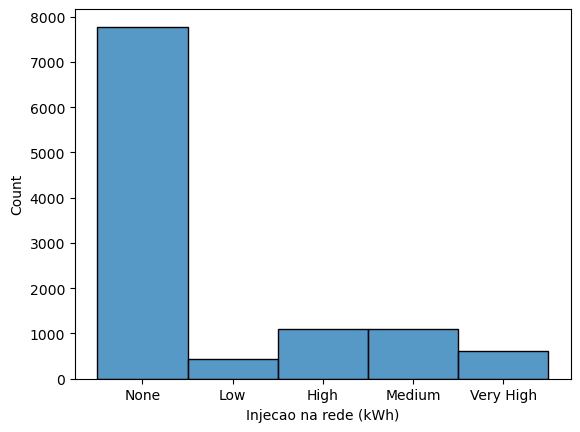

In [261]:
sns.histplot(df_train["Injecao na rede (kWh)"])















"""
f_train=df_train.fillna({'Injecao na rede (kWh)': 'None'})

print (df_train.isna().sum())

sns.histplot(df_train["weather_description"],y=df_train["weather_description"])
sns.histplot(df_2023["weather_description"],y=df_2023["weather_description"])

sns.histplot(df_train["city_name"],y=df_train["city_name"])
sns.histplot(df_2023["city_name"],y=df_2023["city_name"])

print(df_train.describe())




print (df_train.shape) # verfiicar se o número de linhas está correto

print(df_train.info())
"""

In [262]:
df_train['Injecao na rede (kWh)'].value_counts()

Injecao na rede (kWh)
None         7777
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64

O campo weather_description possuem os mesmos valores para o campo weather_description

In [263]:
df_2023['weather_description'].value_counts()

weather_description
sky is clear            739
overcast clouds         305
light rain              299
broken clouds           149
scattered clouds        118
few clouds               70
moderate rain            65
heavy intensity rain      7
Name: count, dtype: int64

c:\Users\simao\miniconda3\envs\envNAME\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\simao\miniconda3\envs\envNAME\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Count', ylabel='weather_description'>

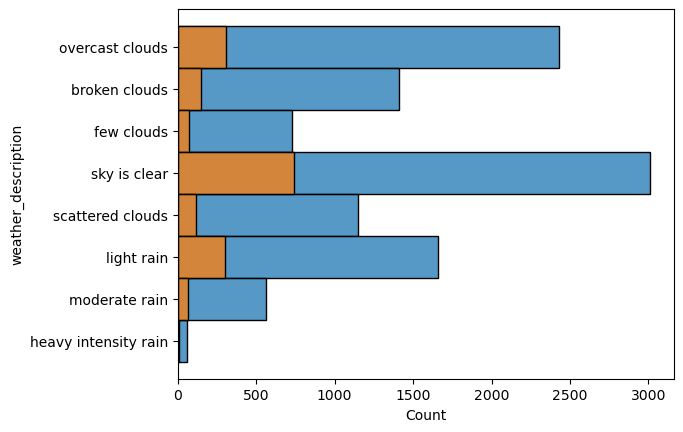

In [264]:
sns.histplot(df_train["weather_description"],y=df_train["weather_description"])
sns.histplot(df_2023["weather_description"],y=df_2023["weather_description"])

Os dados indicam que as medições foram todos realizados numa única cidade,que segundo o enunciado do problema é Braga

c:\Users\simao\miniconda3\envs\envNAME\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\simao\miniconda3\envs\envNAME\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Count', ylabel='city_name'>

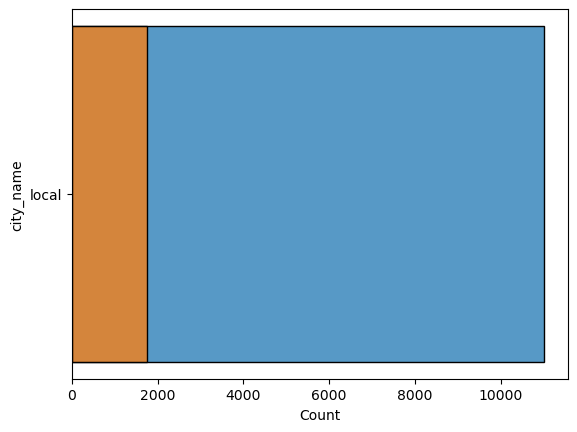

In [265]:
sns.histplot(df_train["city_name"],y=df_train["city_name"])
sns.histplot(df_2023["city_name"],y=df_2023["city_name"])

1-Primavera2-Verao3-Outono4-Inverno

In [266]:
#sns.catplot(x="Estacao", y="pressure", data=df_train, kind="box", aspect=1.5)
#plt.title("Boxplot for Class vs Proline")
#plt.show()


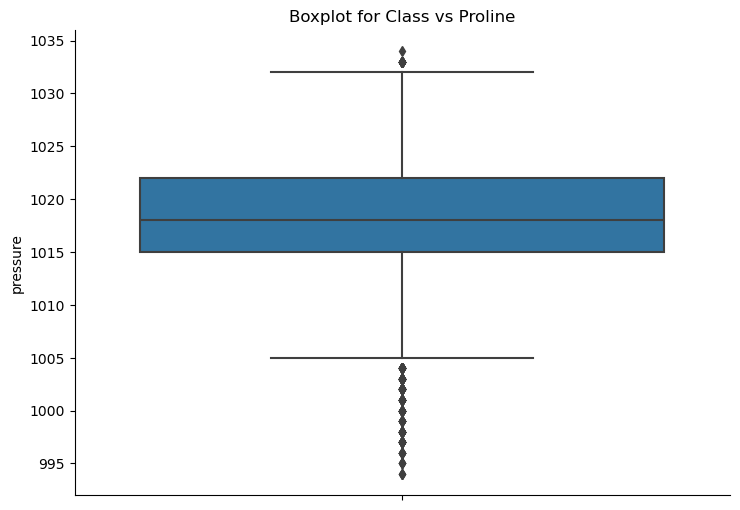

In [267]:
sns.catplot(y="pressure", data=df_train, kind="box", aspect=1.5)
plt.title("Boxplot for Class vs Proline")
plt.show()

In [268]:
#sns.catplot(x="Estacao", y="temp", data=df_train, kind="box", aspect=1.5)
#plt.title("Boxplot for Class vs Proline")
#plt.show()


0- Manhã
1-Tarde
2-Noite


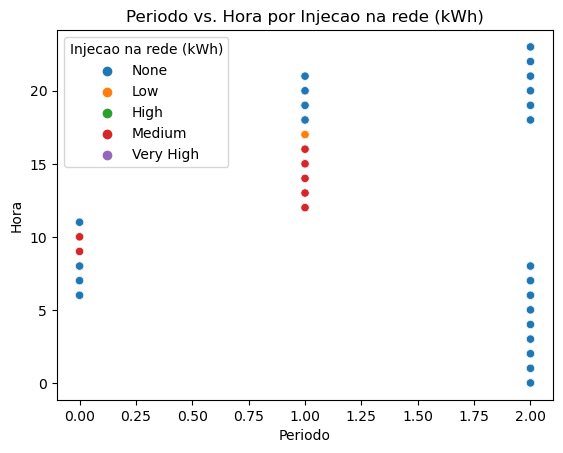

In [269]:
sns.scatterplot(x='Periodo', y='Hora', hue='Injecao na rede (kWh)', data=df_train)
plt.title('Periodo vs. Hora por Injecao na rede (kWh)')
plt.xlabel('Periodo')
plt.ylabel('Hora')
plt.show()

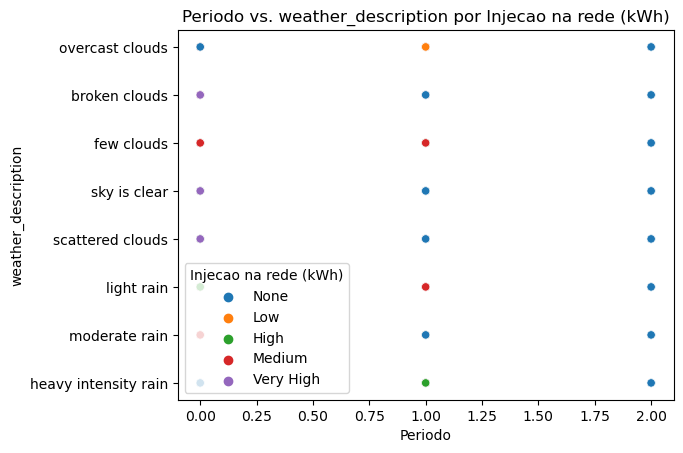

In [270]:
sns.scatterplot(x='Periodo', y='weather_description', hue='Injecao na rede (kWh)', data=df_train)
plt.title('Periodo vs. weather_description por Injecao na rede (kWh)')
plt.xlabel('Periodo')
plt.ylabel('weather_description')
plt.show()

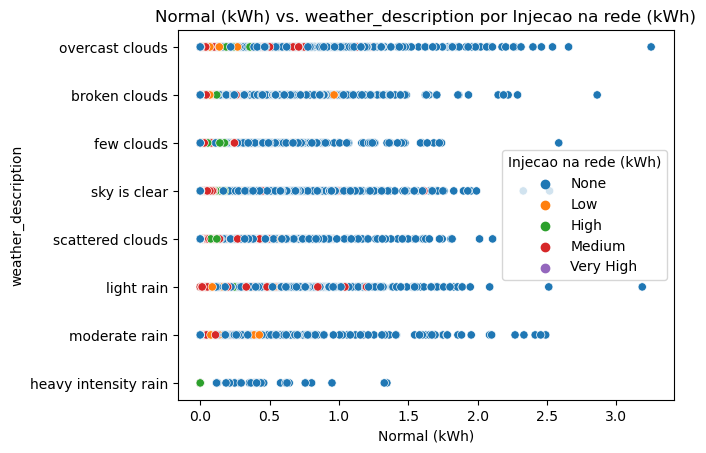

In [271]:
sns.scatterplot(x='Normal (kWh)', y='weather_description', hue='Injecao na rede (kWh)', data=df_train)
plt.title('Normal (kWh) vs. weather_description por Injecao na rede (kWh)')
plt.xlabel('Normal (kWh)')
plt.ylabel('weather_description')
plt.show()

Matriz de Correlação

In [272]:
#correlation_matrix = df_train.corr()
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
#plt.show()

Rank correlation

Hora                         int64
Normal (kWh)               float64
Horario Economico (kWh)    float64
Autoconsumo (kWh)          float64
Injecao na rede (kWh)        int32
dt                           int64
temp                       float64
feels_like                 float64
temp_min                   float64
temp_max                   float64
pressure                     int64
humidity                     int64
wind_speed                 float64
clouds_all                   int64
weather_description          int32
Periodo                      int64
IsNight                       bool
dtype: object


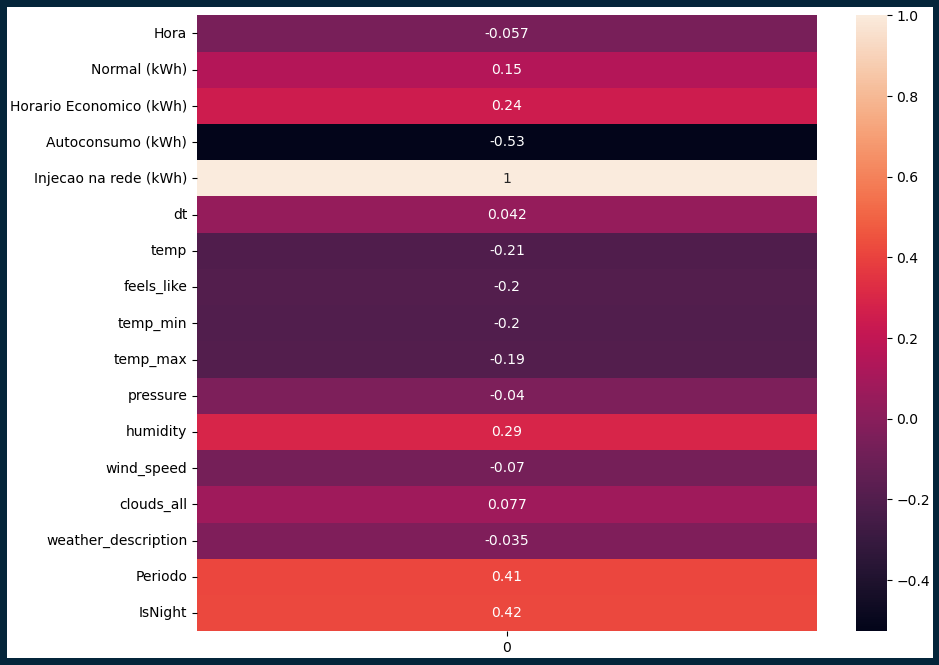

In [273]:
df_train_rank=df_train.copy()
df_train_rank.drop(['sea_level'], axis='columns', inplace=True)
df_train_rank.drop(['grnd_level'], axis='columns', inplace=True)
df_train_rank.drop(['city_name'], axis='columns', inplace=True)
df_train_rank.drop(['Data'], axis='columns', inplace=True)
df_train_rank.drop(['rain_1h'], axis='columns', inplace=True)
df_train_rank.drop(['dt_iso'], axis='columns', inplace=True)
# Inicialize o LabelEncoder
label_encoder = LabelEncoder()

# Aplique o mapeamento ao DataFrame usando o método transform
df_train_rank['Injecao na rede (kWh)'] = label_encoder.fit_transform(df_train_rank['Injecao na rede (kWh)'])
df_train_rank['weather_description'] = label_encoder.fit_transform(df_train_rank['weather_description'])



print(df_train_rank.dtypes)
plt.figure(figsize=(10,8),linewidth=10,edgecolor="#04253a" )
sns.heatmap(df_train_rank.corrwith(df_train_rank['Injecao na rede (kWh)']).to_frame(), annot=True)
plt.show()

teste ao atributo Periodo

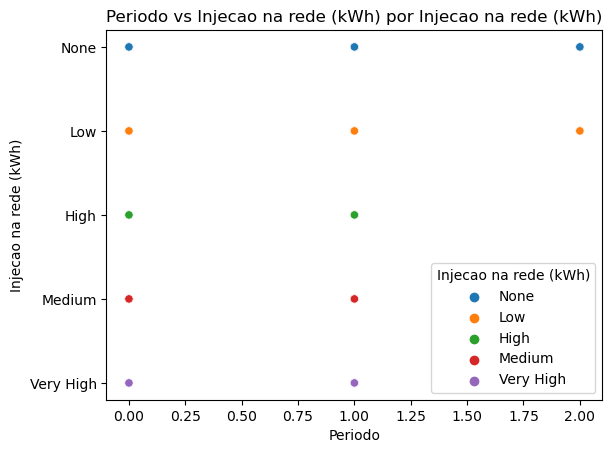

In [274]:
sns.scatterplot(x='Periodo', y='Injecao na rede (kWh)', hue='Injecao na rede (kWh)', data=df_train)
plt.title('Periodo vs Injecao na rede (kWh) por Injecao na rede (kWh)')
plt.xlabel('Periodo')
plt.ylabel('Injecao na rede (kWh)')
plt.show()

No periodo de noite (00-6(inclusive) & 19-23) não existe claramente injeção de energia na rede

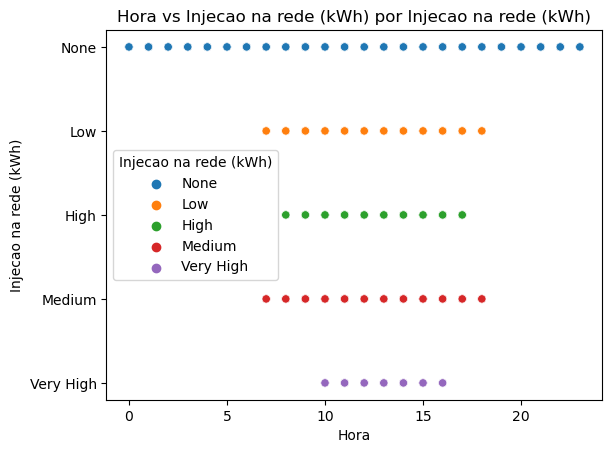

In [275]:
sns.scatterplot(x='Hora', y='Injecao na rede (kWh)', hue='Injecao na rede (kWh)', data=df_train)
plt.title('Hora vs Injecao na rede (kWh) por Injecao na rede (kWh)')
plt.xlabel('Hora')
plt.ylabel('Injecao na rede (kWh)')
plt.show()

In [276]:
injecoes_em_cada_hora = df_train.groupby('Hora')['Injecao na rede (kWh)'].agg(['describe'])
print(injecoes_em_cada_hora)

     describe                       
        count unique        top freq
Hora                                
0         459      1       None  459
1         459      1       None  459
2         459      1       None  459
3         459      1       None  459
4         459      1       None  459
5         459      1       None  459
6         459      1       None  459
7         459      3       None  430
8         459      4       None  238
9         459      4       High  150
10        459      5       High  164
11        459      5  Very High  120
12        459      5  Very High  129
13        459      5       High  133
14        459      5       High  141
15        459      5       None  127
16        459      5       None  215
17        459      4       None  265
18        459      3       None  389
19        459      1       None  459
20        459      1       None  459
21        459      1       None  459
22        459      1       None  459
23        459      1       None  459


<h2>Tratamento de Dados

<h3>Remoção de Atributos

In [277]:
df_train.drop(['dt_iso'], axis='columns', inplace=True)
df_2023.drop(['dt_iso'], axis='columns', inplace=True)

<h4> Remoção de Atributos Correlacionados

In [278]:
#O codigo ainda não está organizado

#Até ao momento temos:
    #feels_like
    #temp_max
    #temp_min

<h3>Tranformação do Tipo de Dados

0        None
1        None
2        None
3        None
4        None
         ... 
11011    None
11012    None
11013    None
11014    None
11015    None
Name: Injecao na rede (kWh), Length: 11016, dtype: category
Categories (5, object): ['None' < 'Low' < 'Medium' < 'High' < 'Very High']
Data                         object
Hora                          int64
Normal (kWh)                float64
Horario Economico (kWh)     float64
Autoconsumo (kWh)           float64
Injecao na rede (kWh)      category
dt                            int64
city_name                    object
temp                        float64
feels_like                  float64
temp_min                    float64
temp_max                    float64
pressure                      int64
sea_level                    object
grnd_level                   object
humidity                      int64
wind_speed                  float64
rain_1h                      object
clouds_all                    int64
weather_description        

c:\Users\simao\miniconda3\envs\envNAME\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\simao\miniconda3\envs\envNAME\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Count', ylabel='weather_description'>

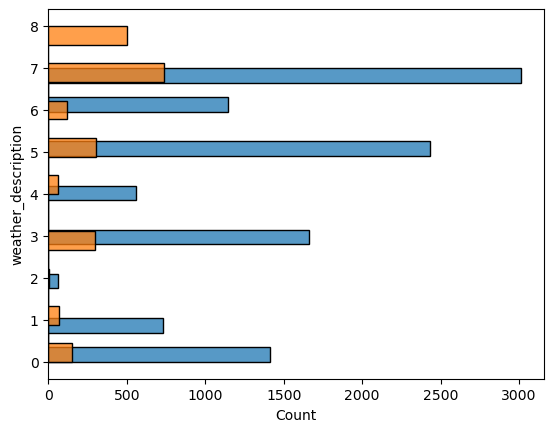

In [279]:
#df_train['Injecao na rede (kWh)']= df_train['Injecao na rede (kWh)'].astype('category')

#label_encoder = LabelEncoder()
#df_train['Injecao na rede (kWh)'] = label_encoder.fit_transform(df_train['Injecao na rede (kWh)'])
#print(df_train["Injecao na rede (kWh)"])
#ordem_personalizada = ['None', 'Low', 'Medium','High','Very High']

# Inicialize o LabelEncoder
#label_encoder = LabelEncoder()

# Ajuste o LabelEncoder para a ordem personalizada
#label_encoder.fit(ordem_personalizada)

# Aplique o mapeamento ao DataFrame usando o método transform
#df_train['Injecao na rede (kWh)'] = label_encoder.fit_transform(df_train['Injecao na rede (kWh)'])

espectro_cat_type = pd.CategoricalDtype(categories=['None', 'Low', 'Medium','High','Very High'], 
                                        ordered=True)
     

df_train['Injecao na rede (kWh)'] = df_train['Injecao na rede (kWh)'].astype(espectro_cat_type)
#print(df_train.dtypes)
print(df_train['Injecao na rede (kWh)'])


#Fazer label encoding do atributo weather_description

label_encoder = LabelEncoder()
#analisar os valores - não há problema (Garantimos que os valores do dataset de treino são os mesmos do dataset de testes)
df_train["weather_description"] = label_encoder.fit_transform(df_train['weather_description'])
print(df_train.dtypes)

df_2023["weather_description"] = label_encoder.fit_transform(df_2023['weather_description'])
print(df_2023["weather_description"])


#Análise feita para verificar que os valores são iguais
sns.histplot(df_train["weather_description"],y=df_train["weather_description"])
sns.histplot(df_2023["weather_description"],y=df_2023["weather_description"])



<h3> Missing Values

In [280]:
#Fizemos alterações mas não estão aqui ainda

#Até ao momento removemos as colunas com missing values 

<h3>Features Engeneering

<h4> Mês

In [281]:
#expressão regular para retirar o Mês através de um grupo de captura
form = re.compile(r'\d{4}-(\d{2})-\d{2}')

data= df_train['Data'].str.extract(form)
df_train['Mes']= pd.to_numeric(data[0])
#df_meteo_2023['Hora']= pd.to_numeric(data[1])
data= df_2023['Data'].str.extract(form)
df_2023['Mes']= pd.to_numeric(data[0])


<h4> Estação do Ano

In [282]:
#função que recebe uma data e determina a estação do ano em que a mesma se encontra
def data_para_estacao(data):
   
    # Divide a data em mês e dia
    mes, dia = data.month, data.day
    
    # Determina a estação com base no mês e dia
    if (mes > 3 and mes <= 5) or (mes == 3 and dia >= 21) or (mes == 6 and dia < 21):
        return 1 #Primavera
    elif (mes >= 6 and mes <= 8) or (mes == 9 and dia < 23):
        return 2 #Verão
    elif (mes >= 9 and mes <= 11) or (mes == 12 and dia < 21) :
        return 3 #Outono
    else:
        return 4 #Inverno

# Aplique a função para obter a estação do ano

df_train['Estacao'] = pd.to_datetime(df_train['Data']).apply(data_para_estacao)


# Aplique a função para obter a estação do ano
df_2023['Estacao'] = pd.to_datetime(df_2023['Data']).apply(data_para_estacao)

<h4> Dia da Semana

In [283]:
df_train['day_of_week'] = pd.to_datetime(df_train['Data']).dt.dayofweek
df_2023['day_of_week'] = pd.to_datetime(df_2023['Data']).dt.dayofweek

def data_para_estacao(dia):

    # Determina a estação com base no mês e dia
    return dia==5 or dia==6

df_train['IsWeekend'] = df_train['day_of_week'].apply(data_para_estacao)
df_2023['IsWeekend'] = df_2023['day_of_week'].apply(data_para_estacao)

df_train.drop(['day_of_week'], axis='columns', inplace=True)
df_2023.drop(['day_of_week'], axis='columns', inplace=True)



<h3>Remoção de Outliers

<h4> Remoção no atributo pressure

In [284]:

#Analisar as estatísticas de pessão em cada estação do ano
estatisticas_por_estacao = df_train.groupby('Estacao')['pressure'].agg(['describe'])

#Renomear as colunas para melhorar a legibilidade
estatisticas_por_estacao.columns = ['count','mean','std','min','25%', '50%', '75%','max']

#calculo do IQR para cada uma das estações do ano
estatisticas_por_estacao['IQR'] = estatisticas_por_estacao['75%'] - estatisticas_por_estacao['25%']

#determinar o valor mínimo e máximo consoante cada estação do ano de modo a poder identificar todos os outliers
estatisticas_por_estacao['out_min'] = estatisticas_por_estacao['50%']-1.5*estatisticas_por_estacao['IQR']
estatisticas_por_estacao['out_max'] = estatisticas_por_estacao['50%']+1.5*estatisticas_por_estacao['IQR']

#guardar apenas os valores de minimo e máximo (únicos valores necessários a identificar os outliers)
estatisticas_por_estacao=estatisticas_por_estacao[['out_min','out_max']]

# Exibe o DataFrame com as estatísticas
print(estatisticas_por_estacao)

# Faz um agrupamento dos DataFrames 'df_train' e 'estatisticas_por_estacao_temp' usando a coluna 'Estacao'
df_train= pd.merge(df_train, estatisticas_por_estacao, on='Estacao', how='left')

# Marca as observações como outliers com base nos limites
df_train = df_train[~((df_train['pressure'] < df_train['out_min']) | (df_train['pressure'] > df_train['out_max']))]

#verificar que existiram alterações no dataframe
print(df_train.shape)

#remover os atributos mínimo e máximo, que já não são mais necessários
df_train.drop(['out_min','out_max'], axis='columns', inplace=True)

         out_min  out_max
Estacao                  
1         1009.5   1024.5
2         1010.0   1022.0
3         1007.0   1031.0
4         1011.5   1038.5
(10414, 27)


<h4> Remoção no atributo temp

In [285]:


#Analisar as estatísticas de pessão em cada estação do ano
estatisticas_por_estacao_temp = df_train.groupby('Estacao')['temp'].agg(['describe'])

# Renomeia as colunas para melhorar a legibilidade
estatisticas_por_estacao_temp.columns = ['count','mean','std','min','25%', '50%', '75%','max']

#calculo do IQR para cada uma das estações do ano
estatisticas_por_estacao_temp['IQR'] = estatisticas_por_estacao_temp['75%'] - estatisticas_por_estacao_temp['25%']

#determinar o valor mínimo e máximo consoante cada estação do ano de modo a poder identificar todos os outliers
estatisticas_por_estacao_temp['out_min'] = estatisticas_por_estacao_temp['50%']-1.5*estatisticas_por_estacao_temp['IQR']
estatisticas_por_estacao_temp['out_max'] = estatisticas_por_estacao_temp['50%']+1.5*estatisticas_por_estacao_temp['IQR']

#guardar apenas os valores de minimo e máximo (únicos valores necessários a identificar os outliers)
estatisticas_por_estacao_temp=estatisticas_por_estacao_temp[['out_min','out_max']]

# Exibe o DataFrame com as estatísticas
print(estatisticas_por_estacao_temp)

#Faz um agrupamento dos DataFrames 'df_train' e 'estatisticas_por_estacao_temp' usando a coluna 'Estacao'
df_train= pd.merge(df_train, estatisticas_por_estacao_temp, on='Estacao', how='left')

# Marca as observações como outliers com base nos limites
df_train = df_train[~((df_train['temp'] < df_train['out_min']) | (df_train['temp'] > df_train['out_max']))]

#verificar que existiram alterações no dataframe
print(df_train.shape)

#remover os atributos mínimo e máximo, que já não são mais necessários
df_train.drop(['out_min','out_max'], axis='columns', inplace=True)

          out_min   out_max
Estacao                    
1         6.50000  27.14000
2        10.82375  31.72625
3         6.03000  23.31000
4         4.56000  19.47000
(9864, 27)


In [286]:

#print(f"History: {df_train["Horario Economico (kWh)"].hist()}")
#sns.histplot(df_train["Horario Economico (kWh)"])
#print(df_train["Horario Economico (kWh)"])
#print(dfCSV.head())
#print(dfXLS.head())






#form = re.compile(r'\d{4}-\d{2}-(\d{2})')
#data= df_train['Data'].str.extract(form)
#df_train['Dia']= pd.to_numeric(data[0])
#data= df_2023['Data'].str.extract(form)
#df_2023['Dia']= pd.to_numeric(data[0])

#df_train['rain_1h'] = df_train['rain_1h'].fillna(0)
#df_2023['rain_1h'] = df_2023['rain_1h'].fillna(0)


Aprendizagem Supervisionada

In [287]:

#remoção de feels_like. Correlação de 1 com a temperatura
#print(y)

# Train the linear regression model
#lm = LinearRegression()
#lm.fit(x, y)

# Your df_2023 data and cleaning operations remain the same



#x = df_train[["Hora","Normal (kWh)","Horario Economico (kWh)","Autoconsumo (kWh)","temp","pressure","humidity","wind_speed","clouds_all","weather_description"]]
x = df_train[["Hora","Normal (kWh)","Horario Economico (kWh)","Autoconsumo (kWh)","temp","pressure","humidity","wind_speed","clouds_all","Mes"]]
y = df_train["Injecao na rede (kWh)"]




df_2023.drop(['Data'], axis='columns', inplace=True)
#df_2023.drop(['Hora'], axis='columns', inplace=True)
df_2023.drop(['city_name'], axis='columns', inplace=True) # remoção devido ao facto dos valores serem todos iguais pelo que não representam nenhum tipo de conhecimento para o modelo
df_2023.drop(['grnd_level'], axis='columns', inplace=True) # remoção por missing values
df_2023.drop(['rain_1h'], axis='columns', inplace=True) ## remoção por missing values
df_2023.drop(['sea_level'], axis='columns', inplace=True) # remoção por missing values
df_2023.drop(['weather_description'], axis='columns', inplace=True) #remoção por missing values (Mesmo que tivesse valores pouco adicoonaria ao modelo - TESTAR HIPOTESE)
df_2023.drop(['dt'], axis='columns', inplace=True) # remoção devido ao facto dos valores serem todos diferentes pelo que não representam nenhum tipo de conhecimento para o modelo
df_2023.drop(['feels_like'], axis='columns', inplace=True) # correlacionado com o atributo temp
df_2023.drop(['temp_max'], axis='columns', inplace=True) # correlacionado com o atributo temp
df_2023.drop(['temp_min'], axis='columns', inplace=True) # correlacionado com o atributo temp
df_2023.drop(['Periodo'], axis='columns', inplace=True) # Teste dos atributos introduzidos por nós
#df_2023.drop(['Mes'], axis='columns', inplace=True)
df_2023.drop(['IsNight'], axis='columns', inplace=True) # Teste aos atributos introduzidos por nós
df_2023.drop(['Estacao'], axis='columns', inplace=True) # Teste aos atributos introduzidos por nós
df_2023.drop(['IsWeekend'], axis='columns', inplace=True) # Teste aos atributos introduzidos por nós


#print (df_2023)


#clf = DecisionTreeClassifier(random_state=2022)

#clf.fit(x, y)

"""
param_grid = {
    'n_estimators': [10,25,50,75,100,150],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# Create a base model
dt = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, refit=True, verbose=2,n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x, y)

dt = grid_search.best_estimator_


param_grid = {
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': [5,7,9,11,13,15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

dt=DecisionTreeClassifier(random_state=2022)
# Use GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,refit=True, verbose=2)
grid_search.fit(x, y)


 
#descobriu os melhores parametros

dt = grid_search.best_estimator_


# Instantiate the LabelEncoder
le = LabelEncoder()

# Fit and transform the target variable
y = le.fit_transform(y)
print(y)

# Create a StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20, 30, 40, 50, None],
    'learning_rate': [ 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.7],
}

# Create a base model
xgb = XGBClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(x, y)

# Get the best estimator
dt = grid_search.best_estimator_
"""
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [30, 50, None],
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7],
    }
# Create a base model
lgbm = LGBMClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(x, y)

# Get the best estimator
dt = grid_search.best_estimator_


print(dt)

# Crie um modelo de Árvore de Decisão
#dt = DecisionTreeClassifier(random_state=42)

my_x=x.copy()
my_y=y.copy()
scores=cross_val_score(dt,my_x,my_y,cv=100)
#print(scores)
print("Accuracy: "+ str(scores.mean()))

#labels=["None","Low","Medium","High","Very High"]
labels=[0, 1, 2, 3, 4]
#y_pred = cross_val_predict(dt, my_x, my_y, cv=10)
#conf_mat = confusion_matrix(my_y, y_pred,labels=labels)

 
print(x.head())
print(df_2023.head())
predict = dt.predict(df_2023)
#predict = dt.fit(df_2023)
print(predict)

# Make predictions
#print(df_2023)
#prediction = lm.predict(df_2023)
prediction1=[]
for elem in predict:
    prediction1.append(elem)


# Create a DataFrame with 'RowId' and 'Result'
data = pd.DataFrame({'RowId': range(1, len(df_2023) + 1), 'Result': prediction1})




# Save the data to a CSV file
#print(predict)
data.to_csv('predictions.csv', index=False)




# Print the predictions
#print("Predictions:")
#print(predict)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\simao\miniconda3\envs\envNAME\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 9864, number of used features: 10
[LightGBM] [Info] Start training from score -2.407675
[LightGBM] [Info] Start training from score -3.243404
[LightGBM] [Info] Start training from score -2.324519
[LightGBM] [Info] Start training from score -0.321500
[LightGBM] [Info] Start training from score -3.035440
LGBMClassifier(colsample_bytree=0.7, max_depth=30, random_state=42,
               subsample=0.5)
[Lig

Data                         object
Hora                          int64
Normal (kWh)                float64
Horario Economico (kWh)     float64
Autoconsumo (kWh)           float64
Injecao na rede (kWh)      category
dt                            int64
city_name                    object
temp                        float64
feels_like                  float64
temp_min                    float64
temp_max                    float64
pressure                      int64
sea_level                    object
grnd_level                   object
humidity                      int64
wind_speed                  float64
rain_1h                      object
clouds_all                    int64
weather_description           int32
Periodo                       int64
IsNight                        bool
Mes                           int64
Estacao                       int64
IsWeekend                      bool
dtype: object


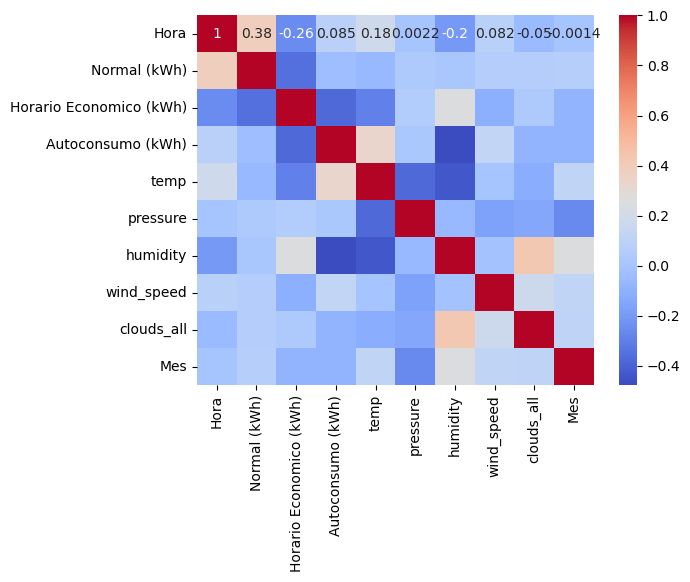

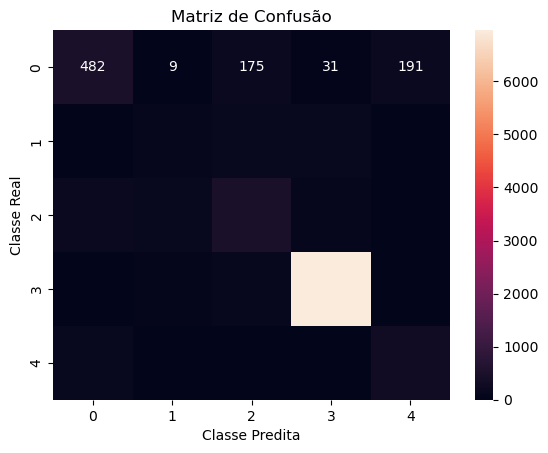

In [288]:
# Features and target
print(df_train.dtypes)

correlation_matrix = x.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Use seaborn para criar um mapa de calor
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

Geração da submission

#### Código antigo


In [289]:
"""
# calculate IQR for column pressure
Q1 = df_train['pressure'].quantile(0.25)
Q3 = df_train['pressure'].quantile(0.75)
IQR = Q3 - Q1

#verificar o número de linhas antes
print(df_train.shape)

# identify outliers
threshold = 1.5
outliers = df_train[(df_train['pressure'] < Q1 - threshold * IQR) | (df_train['pressure'] > Q3 + threshold * IQR)]

#remover os outliers
df_train = df_train.drop(outliers.index)

#verificar o número de linhas depois
print(df_train.shape)
"""


"""
#print(conf_mat)
pl.matshow(conf_mat)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()
"""
"""
num_classes = len(conf_mat)

# Crie uma figura
plt.figure()

# Use matshow para exibir a matriz de confusão como um mapa de calor
plt.matshow(conf_mat, cmap='viridis')

# Adicione rótulos aos eixos
plt.xticks(["Ant", "Bird", "Cat","p","o"])
plt.yticks(["Ant", "Bird", "Cat","p","o"])

# Adicione rótulos específicos às classes
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')

# Adicione os valores da matriz como texto
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(conf_mat[i][j]), ha='center', va='center')

# Adicione uma barra de cores
plt.colorbar()

# Adicione um título
plt.title('Matriz de Confusão')

# Exiba o gráfico
plt.show()
"""



"""
for elem in predict:
    if elem <0.5:
        prediction1.append('High')
    elif elem <1.5:
        prediction1.append('Low')
    elif elem <2.5:
        prediction1.append('Medium') 
    elif elem <3.5:
        prediction1.append('None') 
    elif elem <4.5:
        prediction1.append('Very High') 
"""

"""
# calculate IQR for column temp
Q1 = df_train['temp'].quantile(0.25)
Q3 = df_train['temp'].quantile(0.75)
IQR = Q3 - Q1

#verificar o número de linhas antes
print(df_train.shape)

# identify outliers
threshold = 1.5
outliers = df_train[(df_train['temp'] < Q1 - threshold * IQR) | (df_train['temp'] > Q3 + threshold * IQR)]

#remover os outliers
df_train = df_train.drop(outliers.index)

#verificar o número de linhas depois
print(df_train.shape)
"""


"""
#churn to nominal
df['Churn'] = df['Churn'].astype('category') #.apply(str)
print(df.dtypes)

# fazer um matplotlib com os churns 
#print(df.head())

x = df.drop(['Churn','State','Phone'], axis=1)
y = df['Churn'].to_frame()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2021)

clf = DecisionTreeClassifier(random_state=2021)

clf.fit(x_train, y_train)

predict = clf.predict(x_test)

confusion_matrix = confusion_matrix(y_test, predict)

print(confusion_matrix)

print(confusion_matrix)

accuracy = accuracy_score(y_test, predict)

print(accuracy)

precision = precision_score(y_test, predict)

print(precision)

recall = recall_score(y_test, predict)

print(recall)

"""

"\n#churn to nominal\ndf['Churn'] = df['Churn'].astype('category') #.apply(str)\nprint(df.dtypes)\n\n# fazer um matplotlib com os churns \n#print(df.head())\n\nx = df.drop(['Churn','State','Phone'], axis=1)\ny = df['Churn'].to_frame()\n\nx_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2021)\n\nclf = DecisionTreeClassifier(random_state=2021)\n\nclf.fit(x_train, y_train)\n\npredict = clf.predict(x_test)\n\nconfusion_matrix = confusion_matrix(y_test, predict)\n\nprint(confusion_matrix)\n\nprint(confusion_matrix)\n\naccuracy = accuracy_score(y_test, predict)\n\nprint(accuracy)\n\nprecision = precision_score(y_test, predict)\n\nprint(precision)\n\nrecall = recall_score(y_test, predict)\n\nprint(recall)\n\n"